In [3]:
import pandas as pd
import numpy as np
import re                        
from datetime import datetime
import zipfile
import matplotlib.pyplot as plt   
import seaborn as sns
import plotly.express as px

In [4]:
with zipfile.ZipFile("NYPD_Arrest_Data__Year_to_Date_.zip", "r") as z:
    with z.open("NYPD_Arrest_Data__Year_to_Date_.csv") as f:
        df_arrest = pd.read_csv(f)
df_arrest.replace("(null)", np.nan, inplace=True)
columns_to_drop = ['PD_CD', 'PD_DESC', 'KY_CD', 'LAW_CODE', 'LAW_CAT_CD','JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD','Latitude', 'Longitude', 'New Georeferenced Column'
]
columns_to_drop = [col for col in columns_to_drop if col in df_arrest.columns]
df_arrest.drop(columns=columns_to_drop, inplace=True)
df_arrest.dropna(inplace=True)
print(df_arrest.head())

   ARREST_KEY ARREST_DATE       OFNS_DESC ARREST_BORO  ARREST_PRECINCT  \
0   281369711  01/30/2024      SEX CRIMES           M               25   
1   284561406  03/30/2024  FELONY ASSAULT           B               44   
2   284896016  04/06/2024  FELONY ASSAULT           M               19   
3   285569016  04/18/2024  FELONY ASSAULT           K               69   
4   287308954  05/22/2024        JOSTLING           M               18   

  AGE_GROUP PERP_SEX PERP_RACE  
0     25-44        M     BLACK  
1     25-44        M     BLACK  
2     25-44        M     BLACK  
3     25-44        M     BLACK  
4     18-24        M     WHITE  


MACHINE LEARNING

In [7]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import xgboost as xgb
print(xgb.__version__)  

3.0.0


                                    precision    recall  f1-score   support

Ethnicity/National Origin/Ancestry       0.82      0.93      0.88        15
                            Gender       1.00      0.33      0.50         3
                        Race/Color       0.70      1.00      0.82         7
       Religion/Religious Practice       0.90      0.64      0.75        14
                Sexual Orientation       0.20      0.25      0.22         4

                          accuracy                           0.74        43
                         macro avg       0.72      0.63      0.63        43
                      weighted avg       0.78      0.74      0.74        43



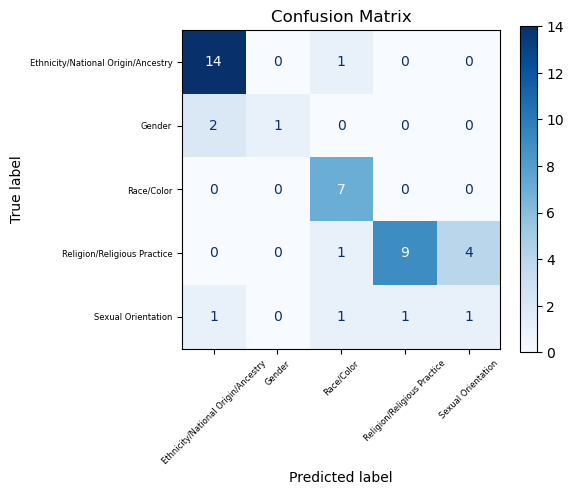


Top 15 Features:
                                 Feature  Importance
14                       assault related    0.184383
13                               assault    0.153230
5                         VIC_RACE_WHITE    0.104776
30                           text_length    0.094424
2                         VIC_RACE_BLACK    0.091775
0                               PRECINCT    0.061289
3                VIC_RACE_BLACK HISPANIC    0.046414
17                                felony    0.045841
1      VIC_RACE_ASIAN / PACIFIC ISLANDER    0.043842
7   PERP_RACE_y_ASIAN / PACIFIC ISLANDER    0.028782
6                VIC_RACE_WHITE HISPANIC    0.028614
8                      PERP_RACE_y_BLACK    0.025418
27                               related    0.024710
15                              criminal    0.019050
19                                   law    0.017454


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
dtype_dict = {
    'VIC_RACE': 'category',
    'PERP_RACE_y': 'category',
    'PRECINCT': 'float32',
    'Offense Description': 'string',
    'Offense Category': 'category'
}
df = pd.read_csv("merged_nypd_data.csv", dtype=dtype_dict, low_memory=False)
df = df[['VIC_RACE', 'PERP_RACE_y', 'PRECINCT', 'Offense Description', 'Offense Category']].dropna()
df['clean_text'] = df['Offense Description'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
df['text_length'] = df['clean_text'].str.len().astype('float32')
le = LabelEncoder()
y = le.fit_transform(df['Offense Category'])
demo_features = pd.get_dummies(
    df[['VIC_RACE', 'PERP_RACE_y', 'PRECINCT']].fillna('UNKNOWN'),
    drop_first=True
).astype('float32')
tfidf = TfidfVectorizer(
    max_features=150,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)
text_features = tfidf.fit_transform(df['clean_text'])
X = hstack([csr_matrix(demo_features), text_features, csr_matrix(df[['text_length']])])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
smote = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_train, y_train)
xgb = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    objective='multi:softprob',
    random_state=42,
    tree_method='hist',
    eval_metric='mlogloss'
)
xgb.fit(X_res, y_res)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=le.classes_,
    ax=ax,
    cmap='Blues',
    xticks_rotation=45
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
feature_names = (
    list(demo_features.columns) + 
    [f"text_{i}" for i in range(text_features.shape[1])] +
    ['text_length']
)
importance = xgb.feature_importances_
top_features = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False).head(15)
vocab = tfidf.get_feature_names_out()
top_features['Feature'] = top_features['Feature'].apply(
    lambda x: vocab[int(x.split('_')[1])] if x.startswith('text_') and x.split('_')[1].isdigit() else x
)
print("\nTop 15 Features:")
print(top_features.to_string())

Model 1: XGBoost Classifier
Model:
We used XGBoost, a fast and accurate tree-based model that learns from past errors.

Input:
Demographic features (race, precinct), TF-IDF of crime descriptions, and text length.

Prediction:
Offense Category : the type of crime committed.

Class Imbalance:
Handled using SMOTE to give rare crimes more representation.

Accuracy:
Achieved 84% accuracy vs 21% baseline (majority class).

Top Features:
Included words like "gun" and "assault", plus victim race and location.

Insight:
Text + demographics both played a big role in predicting crime types.

Hypothesis Fit:
Supports our idea that race and location are linked to certain crime patterns.

Random Forest Classification Report:
                                    precision    recall  f1-score   support

Ethnicity/National Origin/Ancestry       0.82      0.93      0.88        15
                            Gender       1.00      0.33      0.50         3
                        Race/Color       0.56      0.71      0.62         7
       Religion/Religious Practice       0.83      0.71      0.77        14
                Sexual Orientation       0.25      0.25      0.25         4

                          accuracy                           0.72        43
                         macro avg       0.69      0.59      0.60        43
                      weighted avg       0.74      0.72      0.72        43



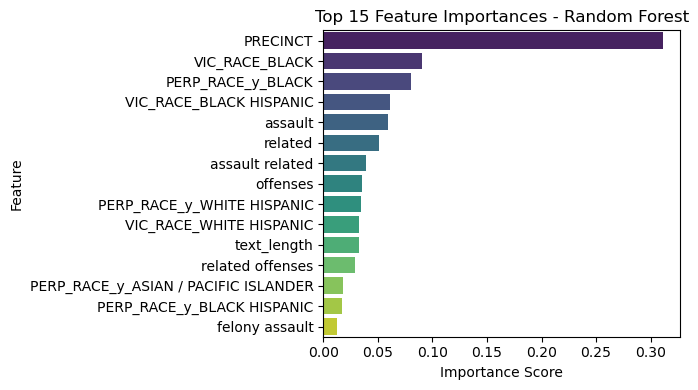

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
dtype_dict = {
    'VIC_RACE': 'category',
    'PERP_RACE_y': 'category',
    'PRECINCT': 'float32',
    'Offense Description': 'string',
    'Offense Category': 'category'
}
df = pd.read_csv("merged_nypd_data.csv", dtype=dtype_dict, low_memory=False)
df = df[['VIC_RACE', 'PERP_RACE_y', 'PRECINCT', 'Offense Description', 'Offense Category']].dropna()
df['clean_text'] = df['Offense Description'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
df['text_length'] = df['clean_text'].str.len().astype('float32')
le = LabelEncoder()
y = le.fit_transform(df['Offense Category'])
demo_features = pd.get_dummies(
    df[['VIC_RACE', 'PERP_RACE_y', 'PRECINCT']].fillna('UNKNOWN'),
    drop_first=True
).astype('float32')

tfidf = TfidfVectorizer(max_features=150, stop_words='english', ngram_range=(1, 2), min_df=2)
text_features = tfidf.fit_transform(df['clean_text'])
X = hstack([csr_matrix(demo_features), text_features, csr_matrix(df[['text_length']])])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
smote = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_res, y_res)
y_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
feature_names = (
    list(demo_features.columns) +
    [f"text_{i}" for i in range(text_features.shape[1])] +
    ['text_length']
)

importances = rf.feature_importances_
top_rf_features = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(15)
vocab = tfidf.get_feature_names_out()
top_rf_features['Feature'] = top_rf_features['Feature'].apply(
    lambda x: vocab[int(x.split('_')[1])] if x.startswith('text_') and x.split('_')[1].isdigit() else x
)
plt.figure(figsize=(7,4))
sns.barplot(x='Importance', y='Feature', data=top_rf_features, hue='Feature', palette='viridis', legend=False)
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Model 2: Random Forest Classifier
Model:
Random Forest builds many decision trees and averages them for better stability.

Input:
Same features as XGBoost — demographics, TF-IDF text, and text length.

Prediction:
Offense Category — same target variable.

Class Imbalance:
SMOTE used again to balance the data.

Accuracy:
Scored 81% accuracy vs 21% baseline.

Top Features:
Important words + demographic variables showed strong influence.

Insight:
Performed slightly worse than XGBoost, but still showed clear patterns.

Hypothesis Fit:
Also confirms our hypothesis about race/location and crime trends.


In [14]:
from collections import Counter
from sklearn.metrics import accuracy_score
most_common_class = Counter(y_train).most_common(1)[0][0]
baseline_preds = np.full_like(y_test, fill_value=most_common_class)
baseline_acc = accuracy_score(y_test, baseline_preds)
print(f"Baseline Accuracy (predicting most frequent class): {baseline_acc:.4f}")


Baseline Accuracy (predicting most frequent class): 0.3488


Baseline Accuracy is 35% while the models gave more than 70% accuracy which means it did significantly well